Int8[

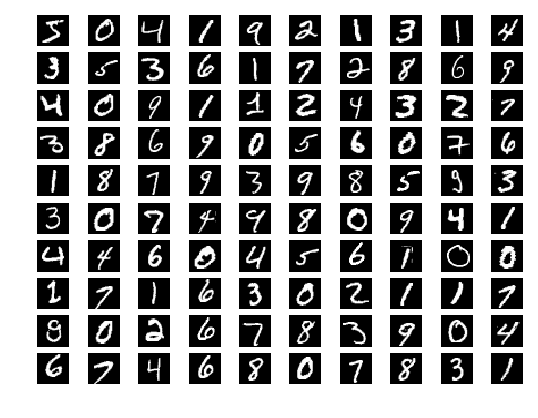

5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1]


In [1]:
using CSV, PyPlot

traindata = CSV.read("mnist_train.csv"; datarow = 1, delim=',', types=fill(UInt8,785));
testdata = CSV.read("mnist_test.csv"; datarow = 1, delim=',', types=fill(UInt8,785));

traindata = traindata[1:300,:]
#testdata = testdata[1:300,:]

n_train,d = size(traindata)
trainY = Int8.(traindata[:,1])
trainX = ones(n_train,d)
n_test,d = size(testdata)
testY = Int8.(testdata[:,1])
testX = ones(n_test,d)

for i=2:d
    trainX[:,i] = Float32.(traindata[:,i])
    testX[:,i] = Float32.(testdata[:,i])
end

figure
num = 10
for i=1:(num*num)
    subplot(num,num,i)
    imshow(reshape(trainX[i,2:end],28,28)', cmap="gray")
    axis("Off")
end
println(Int8.(traindata[1:(num*num),1]))


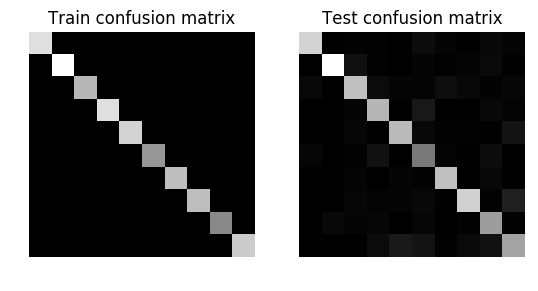

PyObject Text(0.5,1,'Test confusion matrix')


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +1.048e-09  +1.691e+02  +1e+04  1e+00  3e+00  1e+00  1e+00    ---    ---    1  3  - |  -  - 
 1  -3.193e-01  +4.210e+01  +2e+03  4e-02  5e-01  6e-01  2e-01  0.8538  3e-03   3  2  2 |  0  0
 2  -6.344e-01  +5.624e+00  +7e+02  4e-02  2e-02  7e-01  7e-02  0.9280  4e-01   6  4  4 |  0  0
 3  -4.578e-03  +1.326e-01  +2e+01  1e-03  4e-04  7e-03  2e-03  0.9757  3e-04   5  4  4 |  0  0
 4  +9.728e-04  +2.790e-02  +3e+00  2e-04  8e-05  1e-03  4e-04  0.8254  3e-02   1  1  1 |  0  0
 5  +1.303e-03  +7.468e-03  +8e-01  5e-05  2e-05  2e-04  8e-05  0.8430  9e-02   1  1  1 |  0  0
 6  +1.133e-03  +2.601e-03  +2e-01  1e-05  5e-06  3e-05  2e-05  0.8576  1e-01   1  1  1 |  0  0
 7  +1.052e-03  +1.313e-03  +4e-02  3e-06  8e-07  3e-06  4e-06  0.9073  1e-01   1  1  1 |  0  0
 8  +1.091e-03  +1.147e-03  +8e-03  1e-06  2e-

-07  2e-14  3e-12  1e-11  0.8752  5e-01   1  1  1 |  0  0
84  +3.262e-03  +3.262e-03  +2e-07  3e-07  4e-14  4e-12  2e-11  0.0822  1e+00   1  1  1 |  0  0
85  +3.270e-03  +3.270e-03  +3e-07  3e-07  3e-14  6e-12  3e-11  0.9227  9e-01   1  1  1 |  0  0
86  +3.306e-03  +3.306e-03  +2e-07  3e-07  1e-14  4e-12  2e-11  0.4459  2e-01   1  1  1 |  0  0
87  +3.316e-03  +3.316e-03  +2e-07  3e-07  2e-14  6e-12  2e-11  0.9890  9e-01   1  1  1 |  0  0
88  +3.383e-03  +3.383e-03  +9e-08  3e-07  2e-14  2e-12  1e-11  0.9890  3e-01   1  1  1 |  0  0
Slacks/multipliers leaving the cone, recovering best iterate (38) and stopping.

Close to OPTIMAL (within feastol=2.9e-07, reltol=2.6e-04, abstol=5.5e-07).
Runtime: 272.846278 seconds.



In [2]:
using Convex, ECOS

X = trainX
m = 10
y = zeros(Int8, n_train, m)
for i=1:n_train
    y[i,trainY[i]+1] = 1
end

d = size(X,2)
K = size(y,2)
m = K

theta = Variable(d,m)
yhat = X*theta

cost = 0
for i=1:n_train
    yhati = yhat[i,:]
    yi = y[i,:]
    Mi = yhati - yhati*yi
    one_plus_Mi = pos( ones(1,m)-reshape(yi,1,m) + Mi )
    cost += maximum(one_plus_Mi)
end
cost += 1.0*vecnorm(theta[2:end,:])
    
problem = minimize(cost);
solve!(problem, ECOSSolver(verbose=1))
theta_opt = evaluate(theta)
 
C_train = zeros(K,K)
yhat = trainX*theta_opt
vhat = zeros(Int8, n_train)
for i=1:n_train
    maxval, vhat[i] = findmax(yhat[i,:]) 
    C_train[vhat[i],trainY[i]+1] += 1
end

C_test = zeros(K,K)
yhat = testX*theta_opt
vhat = zeros(Int8, n_test)
for i=1:n_test
    maxval, vhat[i] = findmax(yhat[i,:]) 
    C_test[vhat[i],testY[i]+1] += 1
end

figure
subplot(121)
imshow(C_train, cmap="gray")
axis("Off")
title("Train confusion matrix")
subplot(122)
imshow(C_test, cmap="gray")
axis("Off")
title("Test confusion matrix")



In [3]:
Error_rate_train = (sum(C_train) - sum(diag(C_train)))/sum(C_train)
Error_rate_test = (sum(C_test) - sum(diag(C_test)))/sum(C_test)
println(Error_rate_test)


0.2091


In [4]:
C_test


10×10 Array{Float64,2}:
 895.0     0.0   14.0   11.0    2.0   51.0   23.0    8.0   37.0   18.0
   0.0  1082.0   69.0    9.0    3.0   18.0    9.0   24.0   41.0    6.0
  37.0     4.0  812.0   48.0   25.0   17.0   61.0   37.0   14.0   28.0
   4.0     1.0   19.0  768.0    7.0  103.0    1.0    3.0   37.0   20.0
   5.0     4.0   30.0    3.0  788.0   37.0   15.0   15.0    8.0   84.0
  26.0     1.0   10.0   75.0    1.0  509.0   18.0    1.0   52.0    3.0
   5.0     5.0   24.0    2.0   22.0   15.0  814.0    2.0   34.0    7.0
   5.0     1.0   29.0   21.0   22.0   35.0    7.0  885.0   14.0  136.0
   1.0    36.0   22.0   26.0    3.0   26.0    1.0   11.0  665.0   16.0
   2.0     1.0    3.0   47.0  109.0   81.0    9.0   42.0   72.0  691.0